## ML für den Zugversuch: Demonstration

### Importiere alle nötigen Softwarepakete (utils.py ist ein eigenes Python-file mit hilfreichen Funktionen)

In [17]:
from utils import plot_ann, get_stresses, get_strains, get_X_and_y, get_load_displacements, plot_load_displacement_curves, finalize_models
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

### Einlesen von Messkurven und / oder simulierten bzw. berechneten Datensätzen 
##### - 27 Kraft-Weg Kurven unter konstanter Dehnrate (Weg vs. Zeit) sowie entsprechende "Wahre Hauptspannungskurven" mit je 201 Messpunkten 
##### - Der Einfachheit halber wird die Zeit einfach über den Index ausgedrückt, da für jeden Index eine eindeutige Zuordnung zwischen beiden Kurven besteht. 

In [18]:
s_t_filename = "stress_time.csv"
l_d_filename = "force_disp.csv"

s_t = get_stresses(filename=s_t_filename)
l_d = get_load_displacements(filename=l_d_filename)

/root/notebooks/notebooks/ML-demonstration-lesson/Zugversuch/utils.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  l_d.loc[s:s + num_of_measurements_per_curve - 1, "curve"] = str(i)


##### X ist somit eine Matrix der Dimension (27x201) x 2
##### y ist ein Vector mit 27x201 Einträgen

In [19]:
X, y = get_X_and_y(s_t=s_t, l_d=l_d)

(5427, 3)


### Laden, prüfen & bearbeiten der Daten (hier Kraft-Weg-Kurven)

##### Überprüfung der Messung bzw. des Datensatzes durch plotten der Eingangsgrößen (visueller Check)

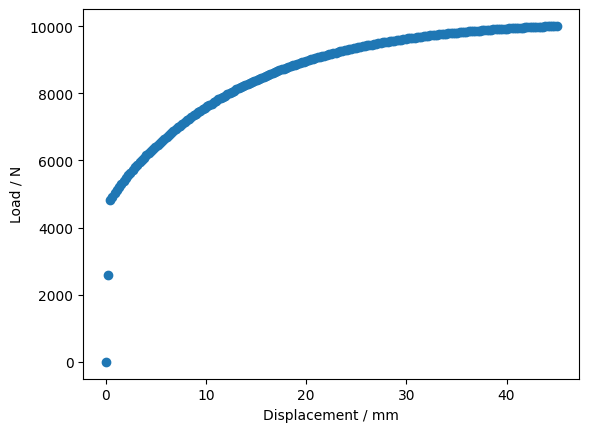

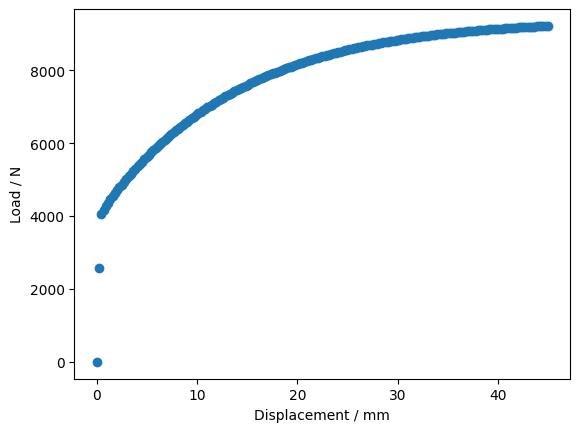

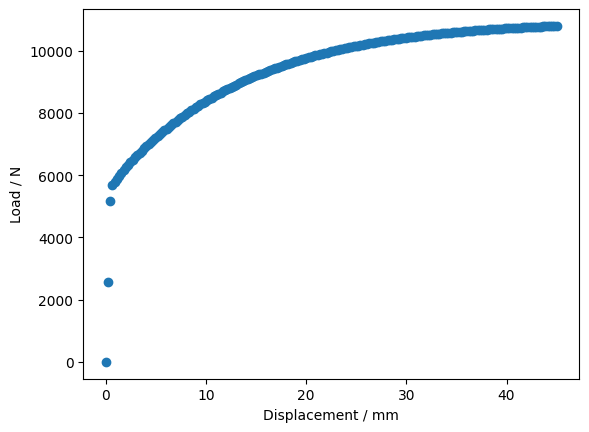

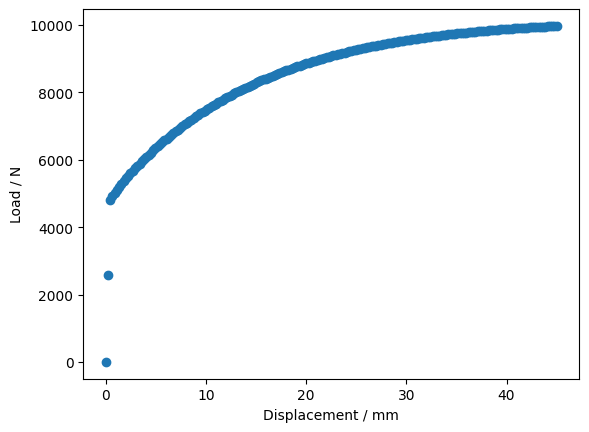

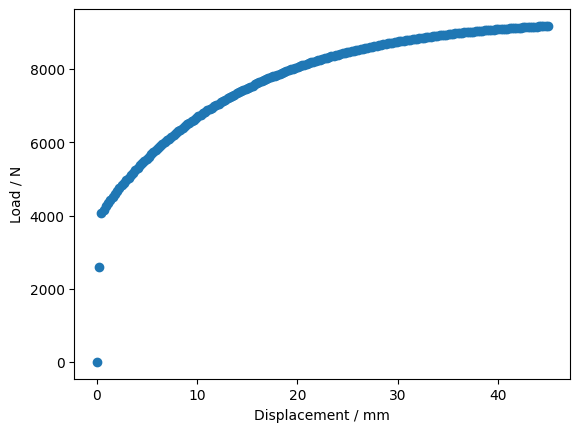

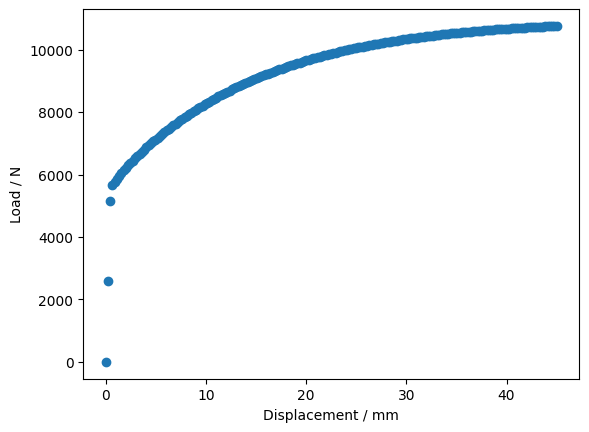

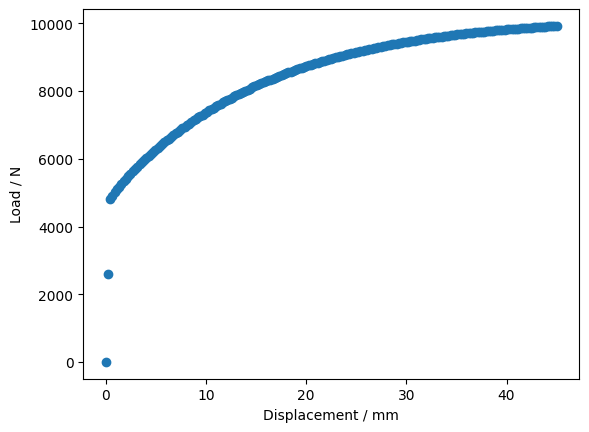

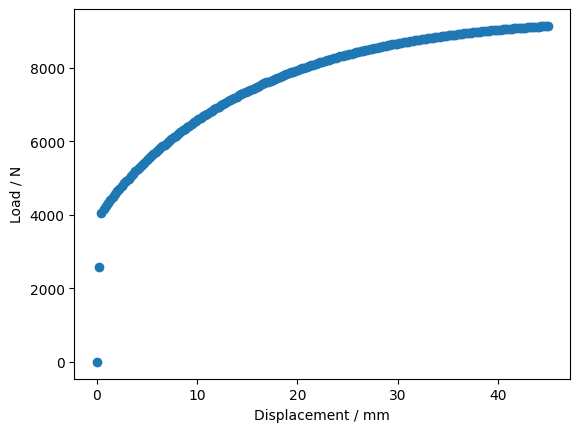

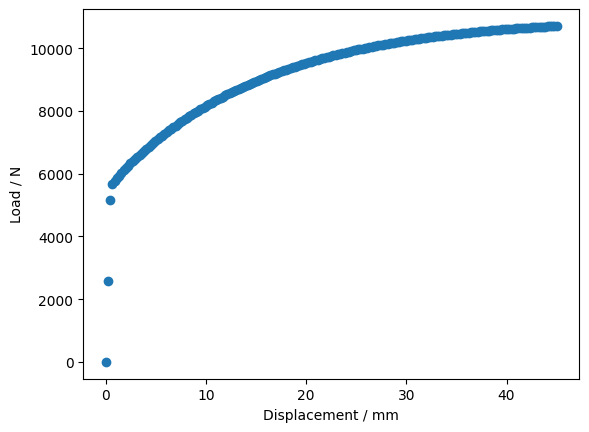

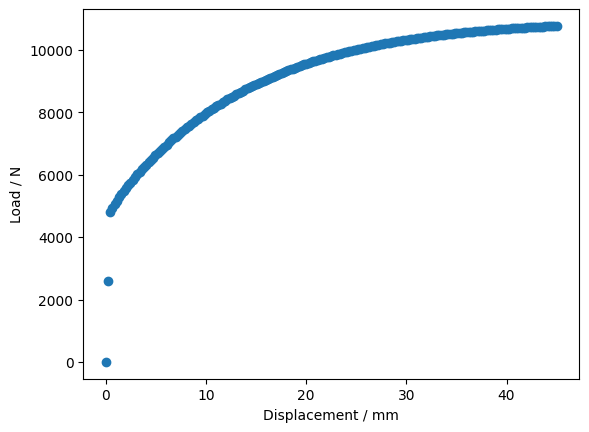

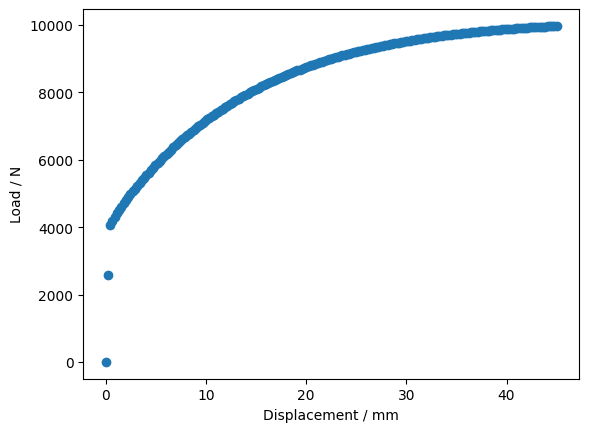

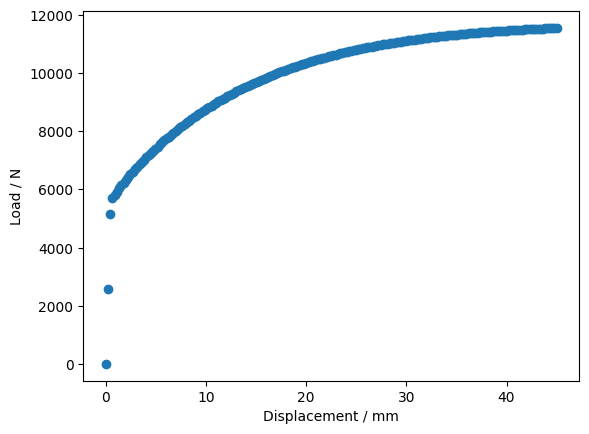

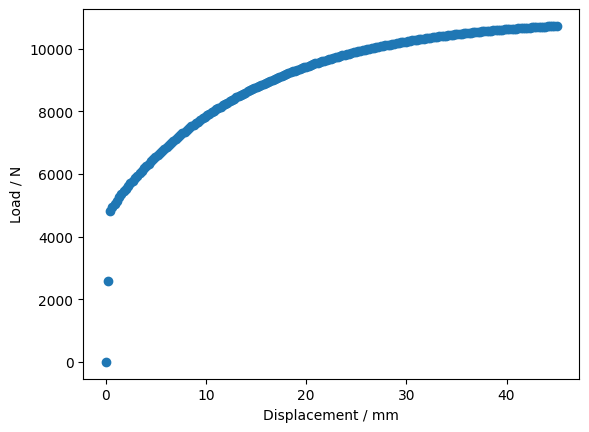

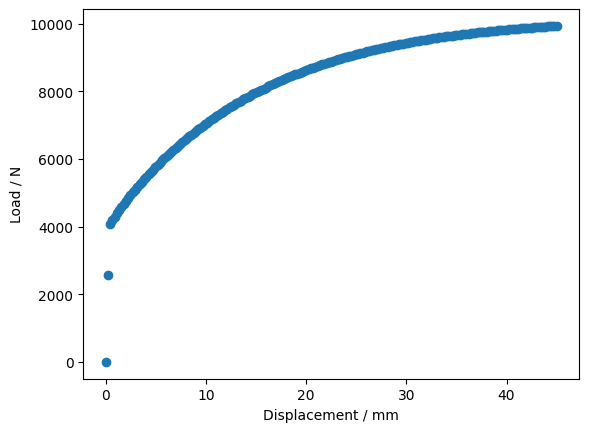

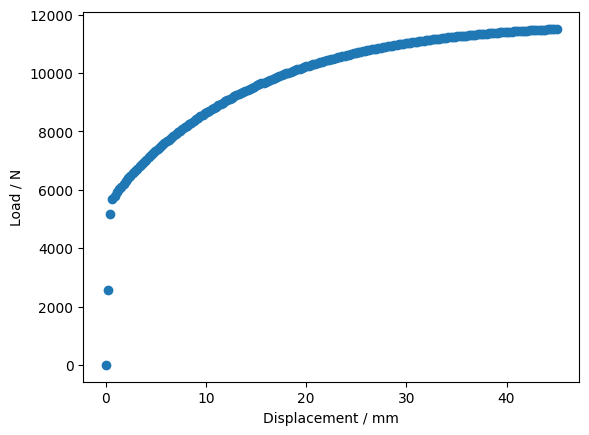

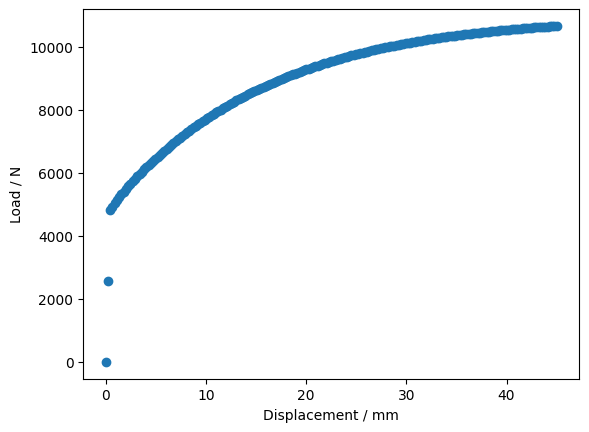

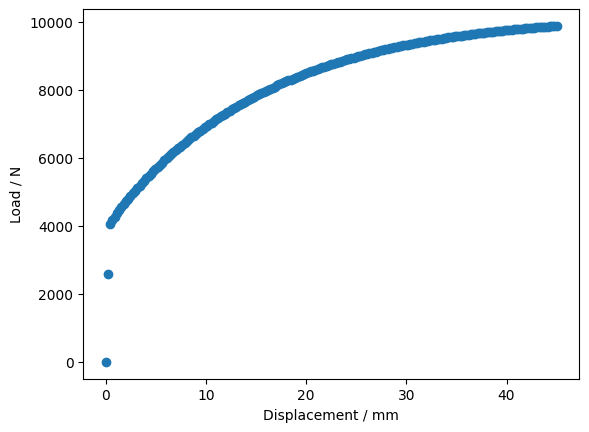

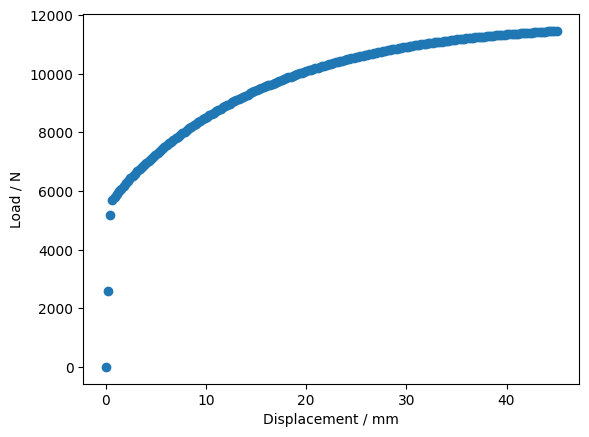

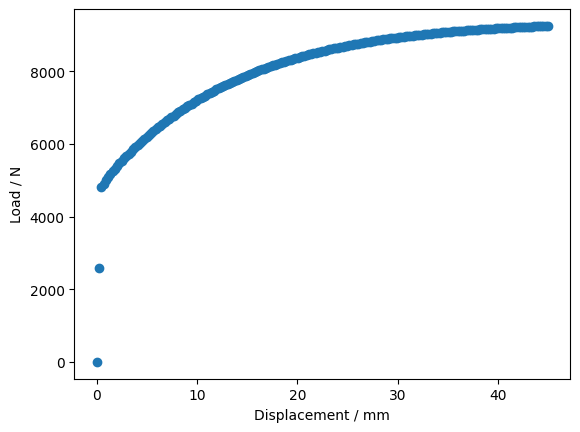

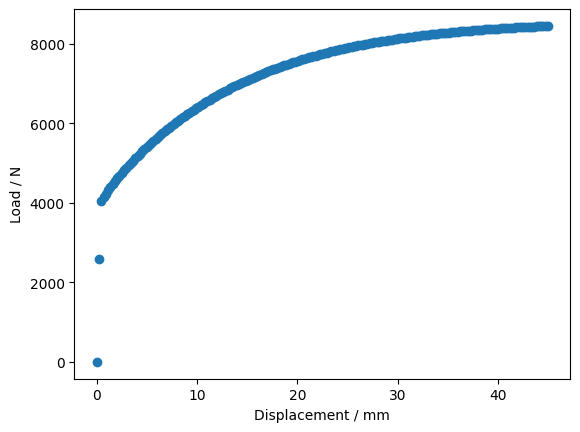

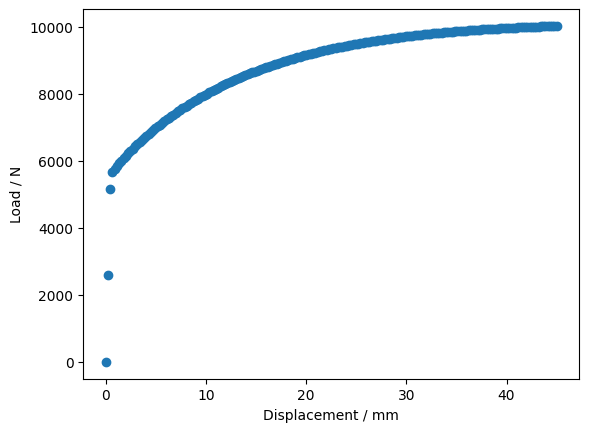

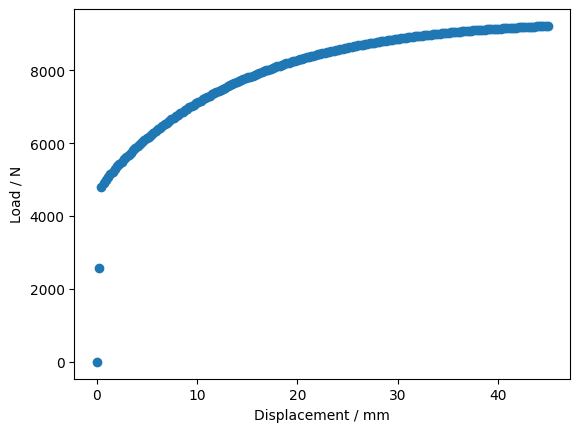

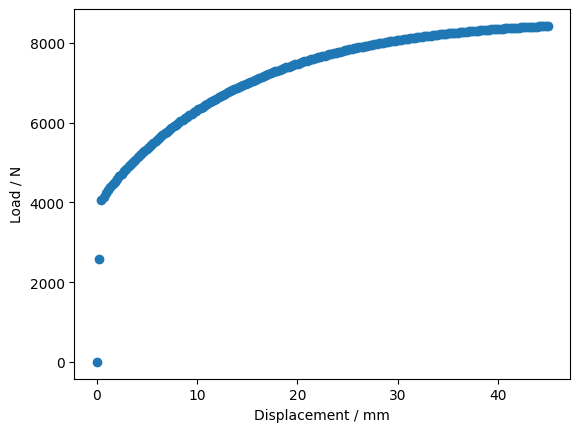

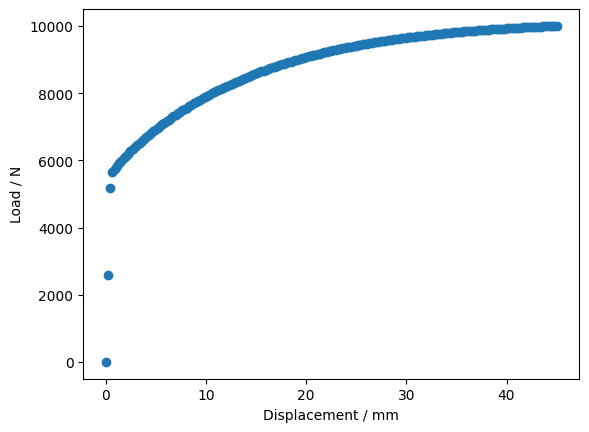

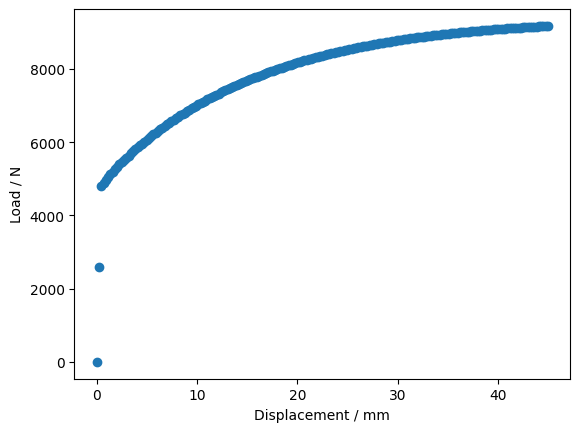

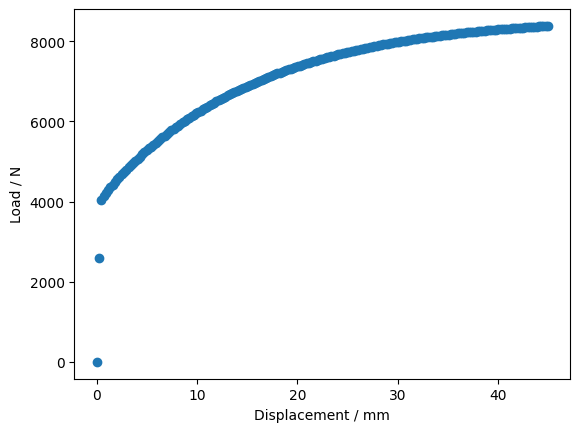

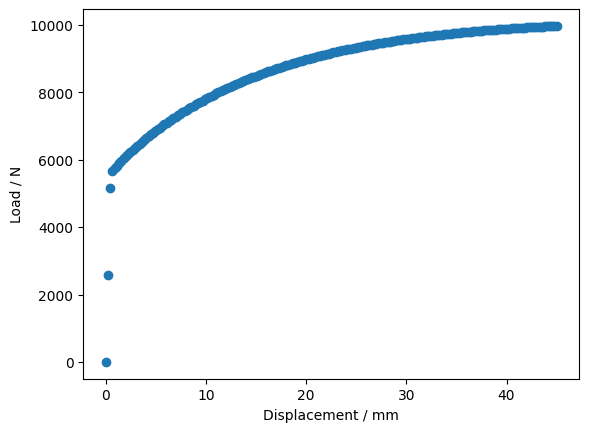

In [20]:
plot_load_displacement_curves(l_d=l_d)

### Trainieren und Verifizieren des Models

#### Teilen der Daten in Trainingsdaten und Testdaten
##### 80/20 Verhältnis mit zufälliger Aufteilung

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

##### Skalierung der Daten (0 bis 1) (wird nur auf Trainingsdaten angewendet um ein Datenleck zu den Testdaten zu vermeiden)

In [22]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Wahl des ML Ansatzes: Hier einfaches ANN (MLP mit 2 Eingaben (Kraft und Weg), 2 Schichten 4,4 und 5,5  Neuronen, 1 Ausgabe (Wahre Spannung)) 
#### Parameter:
##### - MLP Architektur (Anzahl Neuronen der iten "hidden" Schicht)
##### - Aktivierungsfunktion (relu) hier f(x) = max(0, x)
##### - Löser wählen (adam / enhanced SGD) (adam isa stochastic gradient-based optimizer)
##### - Gewichtsanpassung modifizieren (alpha)
##### - Lernrate (lr) an w, an Gradienten koppeln (hier nicht daher "constant")

#### Hier je ein Beispiel für 4 und 5 Neuronen:

In [23]:
model_1 = MLPRegressor(hidden_layer_sizes=(4, 4), activation='relu', solver='adam', alpha=0.1, learning_rate_init=0.001, learning_rate='constant', random_state=7)

model_2 = MLPRegressor(hidden_layer_sizes=(5, 5), activation='relu', solver='adam', alpha=0.1, learning_rate_init=0.001, learning_rate='constant', random_state=7)

### Training der Neuronalen Netze

In [24]:
model_1.fit(X=X_train_scaled, y=y_train)
model_2.fit(X=X_train_scaled, y=y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(5, 5), random_state=7)

### Vorhersage des Test Datensatzes (Eingabe: Kraft-Weg Ausgabe: Wahre Spannung)

In [25]:
model_1_y_pred = model_1.predict(X=X_test_scaled)
model_2_y_pred = model_2.predict(X_test_scaled)

#### Performance Metrik (R², RMSE)

In [26]:
model_1_r2 = r2_score(y_true=y_test, y_pred=model_1_y_pred)
model_1_rmse = mean_squared_error(y_true=y_test, y_pred=model_1_y_pred, squared=False)

model_2_r2 = r2_score(y_true=y_test, y_pred=model_2_y_pred)
model_2_rmse = mean_squared_error(y_true=y_test, y_pred=model_2_y_pred, squared=False)

print(f"Performances of Model 1: \nR2: {model_1_r2}\nRMSE: {model_1_rmse}")
print(f"Performances of Model 2: \nR2: {model_2_r2}\nRMSE: {model_2_rmse}")

Performances of Model 1: 
R2: 0.7090667448688691
RMSE: 0.01178693321237399
Performances of Model 2: 
R2: 0.7644717679504303
RMSE: 0.01060536513927136


#### (5,5) ist akzeptabel. Wie sehen unsere ANNs eigentlich aus? Dafür plotten wir zu Demonstrationszwecken die "Gewichte w".

In [27]:
weights_of_model_1 = model_1.coefs_
weights_of_model_2 = model_2.coefs_

#### ANN 1 (4,4)

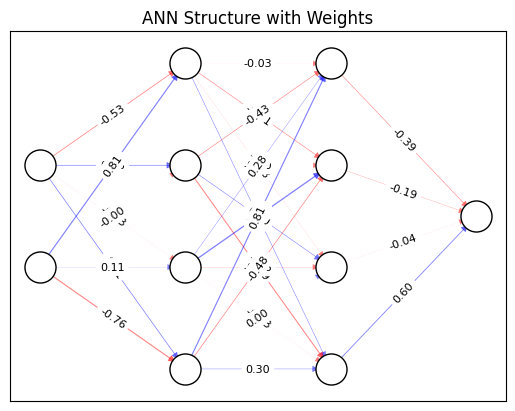

In [28]:
plot_ann(weights=weights_of_model_1, filename="weights_model_1.png")

#### ANN 2 (5,5)

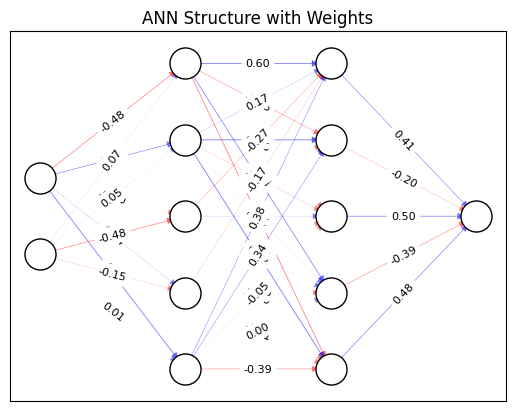

In [29]:
plot_ann(weights_of_model_2, filename="weights_of_model_2.png")

#### Im nächsten Schritt wird das Modell finalisiert. 
##### Das ANN (5,5) wird auf alle Kurven außer Kurve 0 (aus Demonstrationszwecken) trainiert (in utils.py). Zu Optimierungs- bzw. Demonstrationszwecken "spielen" wir noch etwas an der Lernrate lr (0.01 model_1 und 0.001 model_2). 

In [30]:
model_1_finalized, model_2_finalized = finalize_models(X=X, y=y)

### Demonstration der Vorhersagemöglichkeiten des Modelles an Kurve 0

In [31]:
curve_0_X = X.iloc[0:201]
curve_0_y = y.iloc[0:201]

scaler_0 = MinMaxScaler()
scaler_0.fit(curve_0_X)
curve_0_X_scaled = scaler_0.transform(curve_0_X)

curve_0_predicted_from_m1_f = model_1_finalized.predict(curve_0_X_scaled)
curve_0_predicted_from_m2_f = model_2_finalized.predict(curve_0_X_scaled)

m1_f_r2 = r2_score(y_true=curve_0_y, y_pred=curve_0_predicted_from_m1_f)
m2_f_r2 = r2_score(y_true=curve_0_y, y_pred=curve_0_predicted_from_m2_f)

print(f"M1_f: R2: {m1_f_r2}")
print(f"M2_f: R2: {m2_f_r2}")

M1_f: R2: 0.8979714520698657
M2_f: R2: 0.9320361564423404


##### Das Modell konnte verbessert werden.

### Plotten der vorhergesagten Spannungs-Dehungskurve für die "externe" Kurve 0 (hier aus FEM)
##### Einlesen des indexkonformen Dehnungsvektors und Ausgabe der jeweiligen Wahren Spannungen 

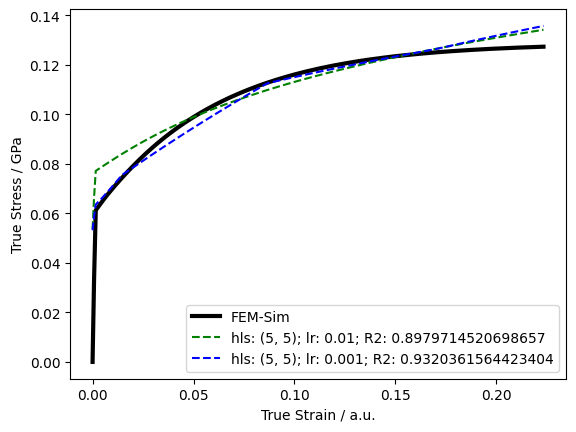

In [32]:
strains = get_strains(filename="time_strain.csv")
strain_0 = strains["0"]

fig, ax = plt.subplots()
ax.plot(strain_0, curve_0_y, color="black", linewidth=3)
ax.plot(strain_0, curve_0_predicted_from_m1_f, color="g", linestyle="--")
ax.plot(strain_0, curve_0_predicted_from_m2_f, color="b", linestyle="--")

ax.set_xlabel("True Strain / a.u.")
ax.set_ylabel("True Stress / GPa")

ax.legend(
    ["FEM-Sim", "hls: (5, 5); lr: 0.01; R2: {}".format(m1_f_r2),
     "hls: (5, 5); lr: 0.001; R2: {}".format(m2_f_r2)])

fig.savefig("stress_strain_curve_comparison.png")
plt.show()
plt.close()

### Gratulation! Sie haben ML erfolgreich für den Zugversuch angewendet.